In [2]:
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import (
    Input,
    Dense,
    Conv2D,
    BatchNormalization,
    MaxPooling2D,
    Dropout,
    Flatten,
    GlobalMaxPooling2D,
)

from sklearn.metrics import confusion_matrix

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255, x_test / 255

x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [4]:
y_train, y_test = y_train.flatten(), y_test.flatten()

y_train.shape, y_test.shape

((50000,), (10000,))

In [5]:
K = len(np.unique(y_test))
K

10

In [12]:
inputs = Input(shape=x_train[0].shape)

x = inputs

for filter_size in [32, 64, 128]:
    x = Conv2D(filter_size, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filter_size, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(0.2)(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(inputs, x)

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [13]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=50,
)

In [ ]:
batch_size = 32
data_generator = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True
)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

r = model.fit(
    train_generator,
    validation_data=(x_test, y_test),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
)

Epoch 1/50
1562/1562 [==============================] - 56s 36ms/step - loss: 1.4258 - accuracy: 0.5051 - val_loss: 1.4577 - val_accuracy: 0.5017
Epoch 2/50
1562/1562 [==============================] - 56s 36ms/step - loss: 0.9880 - accuracy: 0.6554 - val_loss: 1.0176 - val_accuracy: 0.6555
Epoch 3/50
1562/1562 [==============================] - 56s 36ms/step - loss: 0.8411 - accuracy: 0.7085 - val_loss: 0.8157 - val_accuracy: 0.7220
Epoch 4/50
1562/1562 [==============================] - 56s 36ms/step - loss: 0.7569 - accuracy: 0.7396 - val_loss: 0.6456 - val_accuracy: 0.7810
Epoch 5/50
1562/1562 [==============================] - 56s 36ms/step - loss: 0.6908 - accuracy: 0.7654 - val_loss: 0.6956 - val_accuracy: 0.7787
Epoch 6/50
1562/1562 [==============================] - 57s 36ms/step - loss: 0.6317 - accuracy: 0.7835 - val_loss: 0.7285 - val_accuracy: 0.7621
Epoch 7/50
1562/1562 [==============================] - 55s 35ms/step - loss: 0.5917 - accuracy: 0.7973 - val_loss: 0.7008 -

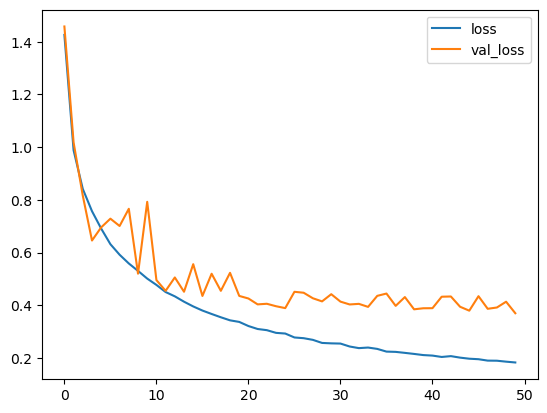

In [16]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

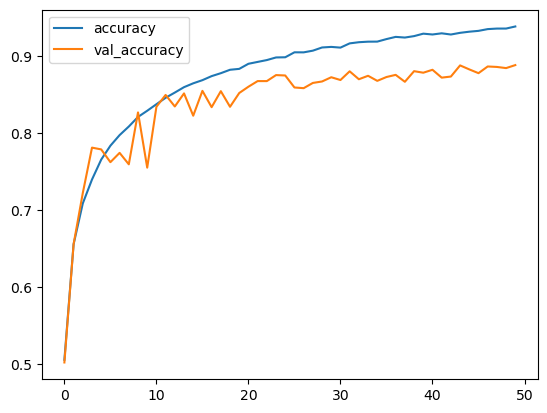

In [17]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

313/313 [==============================] - 3s 11ms/step
Confusion matrix, without normalization
[[898   9  33  12   5   1   1   3  24  14]
 [  5 951   1   2   0   0   0   1  10  30]
 [ 18   1 881  24  27  19  19   3   6   2]
 [ 10   2  33 802  20  76  25  12   7  13]
 [  3   2  45  29 875  11  17  15   3   0]
 [  3   1  39 121  24 785  11  13   1   2]
 [  7   5  31  32   4   3 913   1   1   3]
 [  4   0  10  24  27  22   1 909   0   3]
 [ 28  10   3   7   1   0   1   0 936  14]
 [  9  36   2   3   1   1   0   2  13 933]]


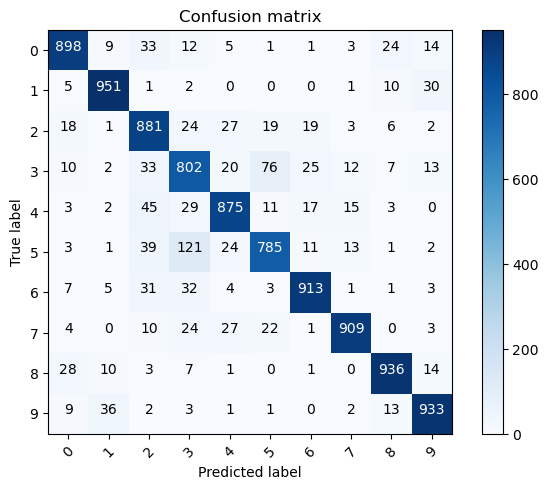

In [18]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [19]:
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

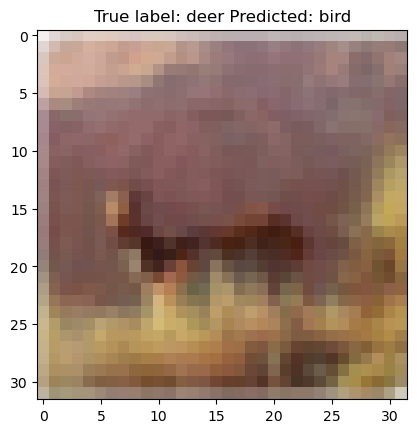

In [20]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]))